# Web Scraping Tutorial Using Python

Web scraping is a term used to describe the use of a program or algorithm to extract and process large amounts of data from the web. Whether you are a data scientist, engineer, or anybody who analyzes large amounts of datasets, the ability to scrape data from the web is a useful skill to have. Let's say you find data from the web and there is no direct way to download it, web scraping using Python is a skill you can use to extract the data into a useful that can be imported.

In this tutorial, you will learn about the following:

•	Data extraction from the web using Python's Beautiful Soup module

•	Data manipulation and cleaning using Python's Pandas library

•	Data visualization using Python's Matplotlib library

The dataset used in this tutorial was taken from a 10K race that took place in Hillsboro, OR on June 2017. Specifically you will analyze the performance of the 10K runners and answer questions such as:

•	What was the average finish time for the runners?

•	Did the runners' finish times follow a normal distribution?

•	Were there any performance differences between males and females of various age groups?

# Web Scraping using Beautiful Soup

Using Jupyter Notebook, you should start by importing the necessary modules (pandas, numpy, matplotlib.pyplot, seaborn). If you don't have Jupyter Notebook installed, I recommend installing it using the Anaconda Python distribution which is available on the internet. To easily display the plots, make sure to include the line %matplotlib inline as shown below. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

To perform web scraping, you should also import the libraries shown below. The urllib.request module is used to open URLs. The Beautiful Soup package is used to extract data from html files. The Beautiful Soup library's name is bs4 which stands for Beautiful Soup, version 4. 

In [2]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

After importing necessary modules, you should specify the URL containing the dataset and pass it to urlopen() to get the html of the page.

In [3]:
url = "http://www.hubertiming.com/results/2017GPTR10K"
html = urlopen(url)

Getting the html of the page is just the first step. Next step is to create a Beautiful Soup object from the html. This is done by passing the html to the BeautifulSoup() function. The Beautiful Soup package is used to parse the html, that is, take the raw html text and break it into Python objects. The second argument 'lxml' is the html parser whose details you do not need to worry about at this point.

In [4]:
soup = BeautifulSoup(html, 'lxml')
type(soup)

bs4.BeautifulSoup

The soup object allows you to extract interesting information about the website you're scraping such as getting the title of the page as shown below.

In [5]:
# Get the title
title = soup.title
print(title)

<title>2017 Intel Great Place to Run 10K \ Urban Clash Games Race Results</title>


You can also get the text of the webpage and quickly print it out to check if it is what you expect.

In [6]:
# Print out the text
text = soup.get_text()
#print(soup.text)

You can view the html of the webpage by right clicking anywhere on the webpage and selecting "Inspect."

You can use the find_all() method of soup to extract useful html tags within a webpage. Examples of useful tags include < a > for hyperlinks, < table > for tables, < tr > for table rows, < th > for table headers, and < td > for table cells. The code below shows how to extract all the hyperlinks within the webpage.

In [7]:
soup.find_all('a')

[<a class="btn btn-primary btn-lg" href="/results/2017GPTR" role="button" style="margin: 0px 0px 5px 5px">5K</a>,
 <a href="http://hubertiming.com/">Huber Timing Home</a>,
 <a href="#individual">Individual Results</a>,
 <a href="#team">Team Results</a>,
 <a href="mailto:timing@hubertiming.com">timing@hubertiming.com</a>,
 <a href="#tabs-1" style="font-size: 18px">Results</a>,
 <a name="individual"></a>,
 <a name="team"></a>,
 <a href="http://www.hubertiming.com/"><img height="65" src="/sites/all/themes/hubertiming/images/clockWithFinishSign_small.png" width="50"/>Huber Timing</a>,
 <a href="http://facebook.com/hubertiming/"><img src="/results/FB-f-Logo__blue_50.png"/></a>]

As you can see from the output above, html tags sometimes come with attributes such as class, src, etc. These attributes provide additional information about html elements. You can use a for loop and the get('"href") method to extract and print out only hyperlinks.

In [8]:
all_links = soup.find_all("a")
for link in all_links:
    print(link.get("href"))

/results/2017GPTR
http://hubertiming.com/
#individual
#team
mailto:timing@hubertiming.com
#tabs-1
None
None
http://www.hubertiming.com/
http://facebook.com/hubertiming/


To print out table rows only, pass the 'tr' argument in soup.find_all().

In [9]:
# Print the first 10 rows for sanity check
rows = soup.find_all('tr')
print(rows[:10])

[<tr><td>Finishers:</td><td>577</td></tr>, <tr><td>Male:</td><td>414</td></tr>, <tr><td>Female:</td><td>163</td></tr>, <tr class="header">
<th>Place</th>
<th>Bib</th>
<th>Name</th>
<th>Gender</th>
<th>City</th>
<th>State</th>
<th>Chip Time</th>
<th>Chip Pace</th>
<th>Gender Place</th>
<th>Age Group</th>
<th>Age Group Place</th>
<th>Time to Start</th>
<th>Gun Time</th>
<th>Team</th>
</tr>, <tr>
<td>1</td>
<td>814</td>
<td>JARED WILSON</td>
<td>M</td>
<td>TIGARD</td>
<td>OR</td>
<td>00:36:21</td>
<td>05:51</td>
<td>1 of 414</td>
<td>M 36-45</td>
<td>1 of 152</td>
<td>00:00:03</td>
<td>00:36:24</td>
<td></td>
</tr>, <tr>
<td>2</td>
<td>573</td>
<td>NATHAN A SUSTERSIC</td>
<td>M</td>
<td>PORTLAND</td>
<td>OR</td>
<td>00:36:42</td>
<td>05:55</td>
<td>2 of 414</td>
<td>M 26-35</td>
<td>1 of 154</td>
<td>00:00:03</td>
<td>00:36:45</td>
<td>INTEL TEAM F</td>
</tr>, <tr>
<td>3</td>
<td>687</td>
<td>FRANCISCO MAYA</td>
<td>M</td>
<td>PORTLAND</td>
<td>OR</td>
<td>00:37:44</td>
<td>06:05</td>
<td

The goal of this tutorial is to take a table from a webpage and convert it into a dataframe for easier manipulation using Python. To get there, you should get all table rows in list form first and then convert that list into a dataframe. Below is a for loop that iterates through table rows and prints out the cells of the rows.

In [10]:
for row in rows:
    row_td = row.find_all('td')
print(row_td)
type(row_td)

[<td>14TH</td>, <td>INTEL TEAM M</td>, <td>04:43:23</td>, <td>00:58:59 - DANIELLE CASILLAS</td>, <td>01:02:06 - RAMYA MERUVA</td>, <td>01:17:06 - PALLAVI J SHINDE</td>, <td>01:25:11 - NALINI MURARI</td>]


bs4.element.ResultSet

The output above shows that each row is printed with html tags embedded in each row. This is not what you want. You can use remove the html tags using Beautiful Soup or regular expressions. 

The easiest way to remove html tags is to use Beautiful Soup and it takes just one line of code to do this. Pass the string of interest into BeautifulSoup() and use the get_text() method to extract the text without html tags.

In [11]:
str_cells = str(row_td)
cleantext = BeautifulSoup(str_cells, "lxml").get_text()
print(cleantext)

[14TH, INTEL TEAM M, 04:43:23, 00:58:59 - DANIELLE CASILLAS, 01:02:06 - RAMYA MERUVA, 01:17:06 - PALLAVI J SHINDE, 01:25:11 - NALINI MURARI]


Using regular expressions is highly discouraged since it requires several lines of code and one can easily make mistakes. It requires importing the re (for regular expressions) module. The code below shows how to build a regular expression that finds all the characters inside the < td > html tags and replace them with an empty string for each table row. 
First, you compile a regular expression by passing a string to match to re.compile(). The dot, star, and question mark (.*?) will match an opening angle bracket followed by anything and followed by a closing angle bracket. It matches text in a non-greedy fashion, that is, it matches the shortest possible string. If you omit the question mark, it will match all the text between the first opening angle bracket and the last closing angle bracket. After compiling a regular expression, you can use the re.sub() method to find all the substrings where the regular expression matches and replace them with an empty string. The full code below generates an empty list, extract text in between html tags for each row, and append it to the assigned list.

In [12]:
import re

list_rows = []
for row in rows:
    cells = row.find_all('td')
    str_cells = str(cells)
    clean = re.compile('<.*?>')
    clean2 = (re.sub(clean, '',str_cells))
    list_rows.append(clean2)
print(clean2)
type(clean2)

[14TH, INTEL TEAM M, 04:43:23, 00:58:59 - DANIELLE CASILLAS, 01:02:06 - RAMYA MERUVA, 01:17:06 - PALLAVI J SHINDE, 01:25:11 - NALINI MURARI]


str

The next step is to convert the list into a dataframe and get a quick view the first 10 rows using Pandas.

In [13]:
df = pd.DataFrame(list_rows)
df.head(10)

,0
0,"[Finishers:, 577]"
1,"[Male:, 414]"
2,"[Female:, 163]"
3,[]
4,"[1, 814, JARED WILSON, M, TIGARD, OR, 00:36:21..."
5,"[2, 573, NATHAN A SUSTERSIC, M, PORTLAND, OR, ..."
6,"[3, 687, FRANCISCO MAYA, M, PORTLAND, OR, 00:3..."
7,"[4, 623, PAUL MORROW, M, BEAVERTON, OR, 00:38:..."
8,"[5, 569, DEREK G OSBORNE, M, HILLSBORO, OR, 00..."
9,"[6, 642, JONATHON TRAN, M, PORTLAND, OR, 00:39..."


# Data Manipulation and Cleaning

The dataframe is not in the format we want. To clean it up, you should split the "0" column into multiple columns at the comma position. This is accomplished by using the str.split() method.

In [14]:
df1 = df[0].str.split(',', expand=True)
df1.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,[Finishers:,577],None,None,None,None,None,None,None,None,None,None,None,None
1,[Male:,414],None,None,None,None,None,None,None,None,None,None,None,None
2,[Female:,163],None,None,None,None,None,None,None,None,None,None,None,None
3,[],None,None,None,None,None,None,None,None,None,None,None,None,None
4,[1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,]
5,[2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F]
6,[3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,]
7,[4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,]
8,[5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F]
9,[6,642,JONATHON TRAN,M,PORTLAND,OR,00:39:49,06:25,6 of 414,M 18-25,1 of 34,00:00:06,00:39:55,]


This looks much better but there is still work to do. The dataframe has unwanted square brackets surrounding each row. You can use the strip() method to remove the opening square bracket on column "0."

In [15]:
df1[0] = df1[0].str.strip('[')
df1.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Finishers:,577],None,None,None,None,None,None,None,None,None,None,None,None
1,Male:,414],None,None,None,None,None,None,None,None,None,None,None,None
2,Female:,163],None,None,None,None,None,None,None,None,None,None,None,None
3,],None,None,None,None,None,None,None,None,None,None,None,None,None
4,1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,]
5,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F]
6,3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,]
7,4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,]
8,5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F]
9,6,642,JONATHON TRAN,M,PORTLAND,OR,00:39:49,06:25,6 of 414,M 18-25,1 of 34,00:00:06,00:39:55,]


The table is missing table headers. You can use the find_all() method to get the table headers.

In [16]:
col_labels = soup.find_all('th')

Similar to table rows, you can use Beautiful Soup to extract text in between html tags for table headers.

In [17]:
all_header = []
col_str = str(col_labels)
cleantext2 = BeautifulSoup(col_str, "lxml").get_text()
all_header.append(cleantext2)
print(all_header)

['[Place, Bib, Name, Gender, City, State, Chip Time, Chip Pace, Gender Place, Age Group, Age Group Place, Time to Start, Gun Time, Team]']


You can then convert the list of headers into a pandas dataframe.

In [18]:
df2 = pd.DataFrame(all_header)
df2.head()

,0
0,"[Place, Bib, Name, Gender, City, State, Chip T..."


Similarly, you can split column "0" into multiple columns at the comma position for all rows.

In [19]:
df3 = df2[0].str.split(',', expand=True)
df3.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,[Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team]


The two dataframes can be concatenated into one using the concat() method as illustrated below.

In [20]:
frames = [df3, df1]

df4 = pd.concat(frames)
df4.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,[Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team]
0,Finishers:,577],None,None,None,None,None,None,None,None,None,None,None,None
1,Male:,414],None,None,None,None,None,None,None,None,None,None,None,None
2,Female:,163],None,None,None,None,None,None,None,None,None,None,None,None
3,],None,None,None,None,None,None,None,None,None,None,None,None,None
4,1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,]
5,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F]
6,3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,]
7,4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,]
8,5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F]


Below shows how to assign the first row to be the table header.

In [21]:
df5 = df4.rename(columns=df4.iloc[0])
df5.head()

,[Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team]
0,[Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team]
0,Finishers:,577],None,None,None,None,None,None,None,None,None,None,None,None
1,Male:,414],None,None,None,None,None,None,None,None,None,None,None,None
2,Female:,163],None,None,None,None,None,None,None,None,None,None,None,None
3,],None,None,None,None,None,None,None,None,None,None,None,None,None


At this point, the table is almost properly formatted. For analysis, you can start by getting an overview of the data as shown below.

In [22]:
df5.info()
df5.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 0 to 595
Data columns (total 14 columns):
[Place              597 non-null object
 Bib                596 non-null object
 Name               593 non-null object
 Gender             593 non-null object
 City               593 non-null object
 State              593 non-null object
 Chip Time          593 non-null object
 Chip Pace          578 non-null object
 Gender Place       578 non-null object
 Age Group          578 non-null object
 Age Group Place    578 non-null object
 Time to Start      578 non-null object
 Gun Time           578 non-null object
 Team]              578 non-null object
dtypes: object(14)
memory usage: 70.0+ KB


(597, 14)

The table has 597 rows and 14 columns. You can drop all rows with any missing values.

In [23]:
df6 = df5.dropna(axis=0, how='any')

Also notice how the table header is replicated as the first row in df5. It can be dropped using the following line of code.

In [24]:
df7 = df6.drop(df6.index[0])
df7.head()

,[Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team]
4,1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,]
5,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F]
6,3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,]
7,4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,]
8,5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F]


You can perform more data cleaning by renaming the '[Place' and ' Team]' columns. Python is very picky about space. Make sure you incude space after the quotation mark in ' Team]'.

In [25]:
df7.rename(columns={'[Place': 'Place'},inplace=True)
df7.rename(columns={' Team]': 'Team'},inplace=True)
df7.head()

,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team
4,1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,]
5,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F]
6,3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,]
7,4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,]
8,5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F]


The final data cleaning step involves removing the closing bracket for cells in the "Team" column. 

In [26]:
df7['Team'] = df7['Team'].str.strip(']')
df7.head()

,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team
4,1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,
5,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F
6,3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,
7,4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,
8,5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F


It took a while to get here but at this point the dataframe is in the desired format. Now you can move on to the exciting part and start plotting the data and computing interesting statistics.

# Data Analysis and Visualization

The first question to answer is, what was the average finish time (in minutes) for the runners? You need to convert the column "Chip Time" into just minutes. One way to do this is to convert the column to a list first for manipulation.

In [27]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 577 entries, 4 to 580
Data columns (total 14 columns):
Place               577 non-null object
 Bib                577 non-null object
 Name               577 non-null object
 Gender             577 non-null object
 City               577 non-null object
 State              577 non-null object
 Chip Time          577 non-null object
 Chip Pace          577 non-null object
 Gender Place       577 non-null object
 Age Group          577 non-null object
 Age Group Place    577 non-null object
 Time to Start      577 non-null object
 Gun Time           577 non-null object
Team                577 non-null object
dtypes: object(14)
memory usage: 67.6+ KB


In [28]:
time_list = df7[' Chip Time'].tolist()

# You can use a for loop to convert 'Chip Time' to minutes

time_mins = []
for i in time_list:
    h, m, s = i.split(':')
    math = (int(h) * 3600 + int(m) * 60 + int(s))/60
    time_mins.append(math)
#print(time_mins)

The next step is to convert the list back into a dataframe and make a new column ("Runner_mins") for runner chip times expressed in just minutes.

In [29]:
df7['Runner_mins'] = time_mins
df7.head()

,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gender Place,Age Group,Age Group Place,Time to Start,Gun Time,Team,Runner_mins
4,1,814,JARED WILSON,M,TIGARD,OR,00:36:21,05:51,1 of 414,M 36-45,1 of 152,00:00:03,00:36:24,,36.350000
5,2,573,NATHAN A SUSTERSIC,M,PORTLAND,OR,00:36:42,05:55,2 of 414,M 26-35,1 of 154,00:00:03,00:36:45,INTEL TEAM F,36.700000
6,3,687,FRANCISCO MAYA,M,PORTLAND,OR,00:37:44,06:05,3 of 414,M 46-55,1 of 64,00:00:04,00:37:48,,37.733333
7,4,623,PAUL MORROW,M,BEAVERTON,OR,00:38:34,06:13,4 of 414,M 36-45,2 of 152,00:00:03,00:38:37,,38.566667
8,5,569,DEREK G OSBORNE,M,HILLSBORO,OR,00:39:21,06:20,5 of 414,M 26-35,2 of 154,00:00:03,00:39:24,INTEL TEAM F,39.350000


Here is how to efficiently do math on a pandas column without converting to a list and then DataFrame again as described above. Thanks to Mirko Savasta!

In [30]:
df7[' Chip Time'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]) + int(x[2])/60)

4       36.350000
5       36.700000
6       37.733333
7       38.566667
8       39.350000
9       39.816667
10      40.066667
11      40.083333
12      40.283333
13      40.350000
14      40.466667
15      40.600000
16      40.716667
17      41.016667
18      41.316667
19      41.716667
20      41.983333
21      42.383333
22      42.483333
23      42.583333
24      42.600000
25      42.616667
26      42.933333
27      43.433333
28      43.450000
29      43.666667
30      43.700000
31      43.716667
32      43.766667
33      43.766667
          ...    
551     83.500000
552     83.500000
553     83.750000
554     83.900000
555     84.150000
556     84.316667
557     85.183333
558     85.816667
559     85.816667
560     86.366667
561     87.133333
562     88.316667
563     88.550000
564     89.066667
565     89.066667
566     91.333333
567     92.166667
568     92.300000
569     92.333333
570     92.466667
571     92.500000
572     93.833333
573     94.750000
574     94.800000
575     97

The code below shows how to calculate statistics for numeric columns only in the dataframe.

In [31]:
df7.describe(include=[np.number])

,Runner_mins
count,577.000000
mean,60.035933
std,11.970623
min,36.350000
25%,51.000000
50%,59.016667
75%,67.266667
max,101.300000


Interestingly, the average chip time for all runners was ~60 mins. The fastest 10K runner finished in 36.35 mins and the slowest runner finished in 101.30 minutes. 

A boxplot is another useful tool to visualize summary statistics (maximum, minimum, medium, first quartile, third quartile, including outliers). Below are data summary statistics for the runners shown in a boxplot. For data visualization, it is convenient to first import parameters from the pylab module that comes with matplotlib and set the same size for all figures to avoid doing it for each figure.

In [32]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

([<matplotlib.axis.XTick at 0x6eed57e978>],
 <a list of 1 Text xticklabel objects>)

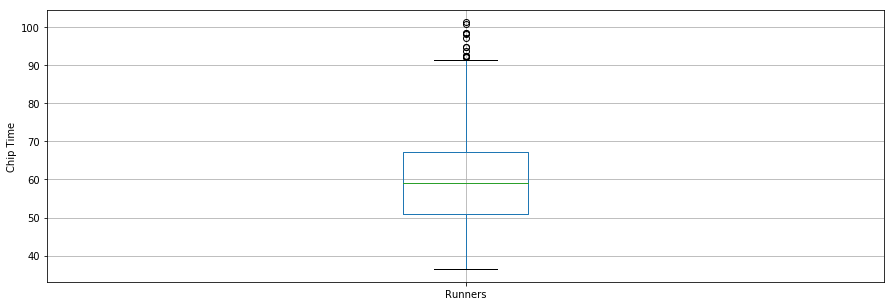

In [33]:
df7.boxplot(column='Runner_mins')
plt.grid(True, axis='y')
plt.ylabel('Chip Time')
plt.xticks([1], ['Runners'])

The second question to answer is: Did the runners' finish times follow a normal distribution?

Below is a distribution plot of runners' chip times plotted using the seaborn library. The distribution looks almost normal.

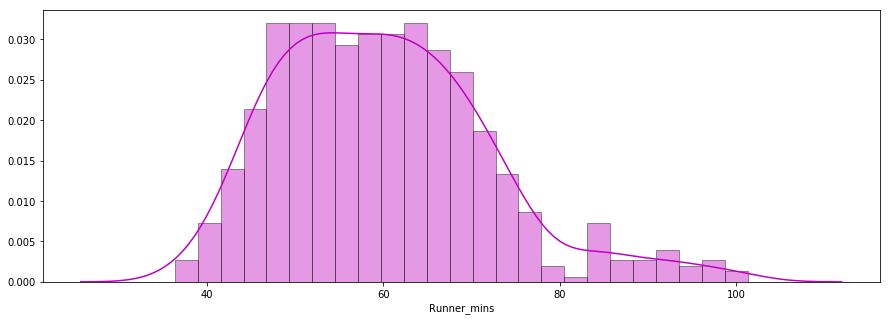

In [34]:
x = df7['Runner_mins']
ax = sns.distplot(x, hist=True, kde=True, rug=False, color='m', bins=25, hist_kws={'edgecolor':'black'})
plt.show()

The third question deals with whether there were any performance differences between males and females of various age groups. Below is a distribution plot of chip times for males and females.

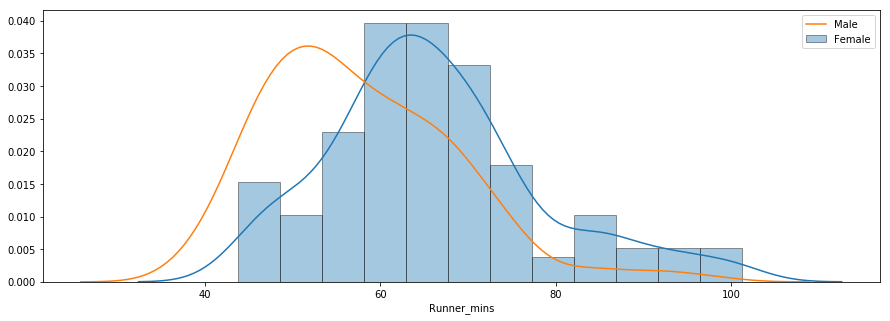

In [35]:
f_fuko = df7.loc[df7[' Gender']==' F']['Runner_mins']
m_fuko = df7.loc[df7[' Gender']==' M']['Runner_mins']
sns.distplot(f_fuko, hist=True, kde=True, rug=False, hist_kws={'edgecolor':'black'}, label='Female')
sns.distplot(m_fuko, hist=False, kde=True, rug=False, hist_kws={'edgecolor':'black'}, label='Male')
plt.legend()

The distribution indicates that females were slower than males on average. You can use the groupby() method to compute summary statistics for males and females separately as shown below.

In [36]:
g_stats = df7.groupby(" Gender", as_index=True).describe()
print(g_stats)

        Runner_mins                                                         \
              count       mean        std        min        25%        50%   
 Gender                                                                      
 F            163.0  66.119223  12.184440  43.766667  58.758333  64.616667   
 M            414.0  57.640821  11.011857  36.350000  49.395833  55.791667   

                                
               75%         max  
 Gender                         
 F       72.058333  101.300000  
 M       64.804167   98.516667  


The average chip time for all females and males was ~66 mins and ~58 mins, respectively. Below is a side-by-side boxplot comparison of male and female finish times.

C:\Users\smasango\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,0.98,'')

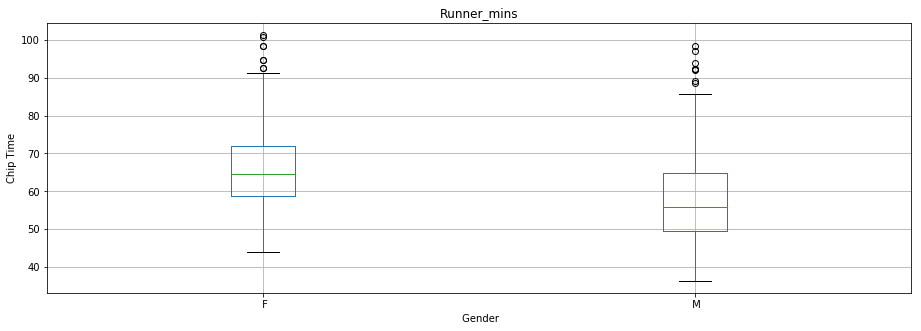

In [37]:
df7.boxplot(column='Runner_mins', by=' Gender')
plt.ylabel('Chip Time')
plt.suptitle("")

# Conclusion

In this tutorial you performed web scraping using Python. You used the Beautiful Soup library to parse html data and convert it into a form that can be used for analysis. You performed cleaning of the data in Python and created useful plots (boxplots, barplots, and distribution plots) to reveal interesting trends using Python's matplotlib and seaborn libraries. After this tutorial, you should be able to use Python to easily scrape data from the web, apply cleaning techniques and extract useful insights from the data.